In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [3]:
n_clusters = 6
n_samples = 250

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [7]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

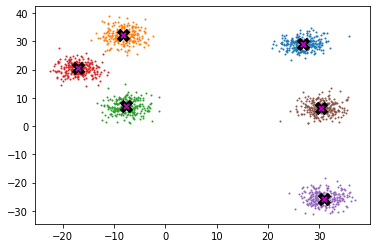

In [9]:
plot_data(centroids, data, n_samples)

### K-Means clustering algorithm:

1. Choose number of clusters and randomly initialize centroids (this is what k in k-means stands for)
2. Calculate the distance of every point from every centriod
3. Assign the point to the nearest centroid
4. Calculate the mean of all the clusters
5. Update the centroid with the calculated mean
6. Repeat the process until the centroids have converged

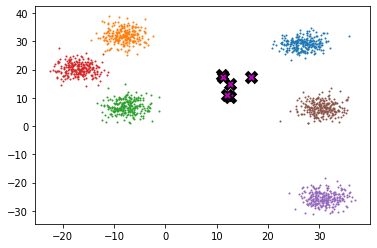

In [132]:
torch.manual_seed(100)
new_centroids = torch.rand(n_clusters, 2)*10+10

plot_data(new_centroids, data, n_samples)

In [133]:
X = data.clone()
new_centroids.shape, X.shape

(torch.Size([6, 2]), torch.Size([1500, 2]))

In [134]:
x = X[0]
x.shape, new_centroids.shape

(torch.Size([2]), torch.Size([6, 2]))

In [135]:
dist = ((x-new_centroids)**2).sum(1).sqrt()
dist

tensor([17.167, 17.800, 12.911, 20.923, 20.726, 17.478])

In [136]:
dist.argmin()

tensor(2)

In [137]:
x, new_centroids[2]

(tensor([26.204, 26.349]), tensor([16.765, 17.539]))

In [138]:
def one_update(X, centroids):
    res = [[] for _ in range(len(centroids))]
    for x in X:
        dist = ((x-centroids)**2).sum(1).sqrt() 
        ind = dist.argmin()
        res[ind].append(x)
        
    result = []
    for i, l in enumerate(res):
        if len(res[i]) == 0:
            result.append(centroids.mean(0))
        else:
            result.append(torch.stack(l).mean(0))
            
    return torch.stack(result)

In [139]:
updated_centroids = one_update(X, new_centroids)

In [140]:
updated_centroids

tensor([[-12.581,  26.251],
        [ 12.739,  14.917],
        [ 28.569,  19.926],
        [ 30.497, -19.250],
        [ -7.629,   6.858],
        [-10.146,  13.490]])

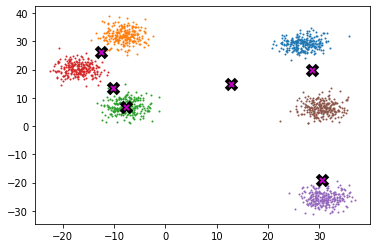

In [141]:
plot_data(updated_centroids, data, n_samples)

In [142]:
def k_means(data):
    X = data.clone()
    nc = one_update(X, new_centroids)
    for _ in range(50):
        nc = one_update(X, nc)
        
    return nc

In [145]:
%time final_centroids = k_means(data)

CPU times: user 1.16 s, sys: 2.5 ms, total: 1.16 s
Wall time: 1.17 s


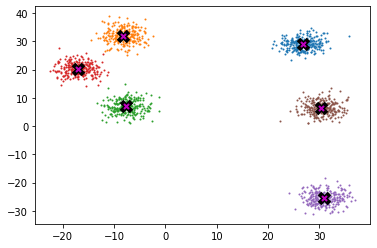

In [146]:
plot_data(final_centroids, data, n_samples)

### K-Means on GPU

In [178]:
def kmeans_gpu(data, centroids, max_iters=50):
    X = data.clone()
    
    for _ in range(max_iters):
        # Step 1: Assign each point to the nearest centroid
        dists = torch.cdist(X, centroids.cuda())  # [N, K]
        ind_min = dists.argmin(dim=1)      # [N]
        
        # Step 2: Update centroids
        res = []
        for c in range(centroids.shape[0]):
            assigned = X[ind_min == c]
            if assigned.size(0) == 0:
                res.append(centroids.mean(0).cuda())  # fallback: global mean
            else:
                res.append(assigned.mean(0))
        
        updated_centroids = torch.stack(res)
        
        # Optionally: stop if centroids don't change
        if torch.allclose(centroids.cuda(), updated_centroids, atol=1e-4):
            break
        
        centroids = updated_centroids  # update for next iteration

    return centroids


In [179]:
data = data.cuda()

In [181]:
%time final_centroids = kmeans_gpu(data, new_centroids)

CPU times: user 6.26 ms, sys: 570 µs, total: 6.83 ms
Wall time: 5.65 ms


In [182]:
final_centroids = final_centroids.cpu(); final_centroids

tensor([[ -8.179,  32.048],
        [ 30.427,   6.500],
        [ 26.780,  29.194],
        [ 30.937, -25.434],
        [ -7.635,   6.958],
        [-16.998,  20.357]])

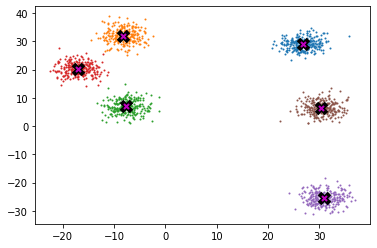

In [184]:
plot_data(final_centroids, data.cpu(), n_samples)